In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split # test, cv 나누는 라이브러리
from sklearn.linear_model import LinearRegression 
from warnings import simplefilter

rcParams['figure.figsize'] = (16,8)
plt.style.use('fivethirtyeight')
simplefilter('ignore')


In [2]:
data_dir = Path(r'C:\Users\789\Desktop\github_local\Machine Learning\machine-learning-projects\data\movie_dacon')
trn_file = data_dir / 'movies_train.csv'
seed = 42

df = pd.read_csv(trn_file, index_col=0)
print(df.shape)
df.head()

(600, 11)


,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
title,,,,,,,,,,,
개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


## EDA Exploratory Data Analysis

In [3]:
df.info() # 데이터의 각 열의 데이터 타입과 null 확인

<class 'pandas.core.frame.DataFrame'>
Index: 600 entries, 개들의 전쟁 to 베를린
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   distributor     600 non-null    object 
 1   genre           600 non-null    object 
 2   release_time    600 non-null    object 
 3   time            600 non-null    int64  
 4   screening_rat   600 non-null    object 
 5   director        600 non-null    object 
 6   dir_prev_bfnum  270 non-null    float64
 7   dir_prev_num    600 non-null    int64  
 8   num_staff       600 non-null    int64  
 9   num_actor       600 non-null    int64  
 10  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(5)
memory usage: 56.2+ KB


In [4]:
df.fillna(0, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 600 entries, 개들의 전쟁 to 베를린
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   distributor     600 non-null    object 
 1   genre           600 non-null    object 
 2   release_time    600 non-null    object 
 3   time            600 non-null    int64  
 4   screening_rat   600 non-null    object 
 5   director        600 non-null    object 
 6   dir_prev_bfnum  600 non-null    float64
 7   dir_prev_num    600 non-null    int64  
 8   num_staff       600 non-null    int64  
 9   num_actor       600 non-null    int64  
 10  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(5)
memory usage: 56.2+ KB


In [5]:
df.describe()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
count,600.000000,6.000000e+02,600.000000,600.000000,600.000000,6.000000e+02
mean,100.863333,4.726993e+05,0.876667,151.118333,3.706667,7.081818e+05
std,18.097528,1.309474e+06,1.183409,165.654671,2.446889,1.828006e+06
min,45.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
25%,89.000000,0.000000e+00,0.000000,17.000000,2.000000,1.297250e+03
50%,100.000000,0.000000e+00,0.000000,82.500000,3.000000,1.259100e+04
75%,114.000000,3.761416e+05,2.000000,264.000000,4.000000,4.798868e+05
max,180.000000,1.761531e+07,5.000000,869.000000,25.000000,1.426277e+07


In [6]:
target_col = 'box_off_num'
pred_col = 'pred'
num_cols = [x for x in df.columns if df[x].dtype in [np.float64, np.int64] and x != target_col]
# numerical variable columns
print(num_cols)

['time', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor']


<Axes: >

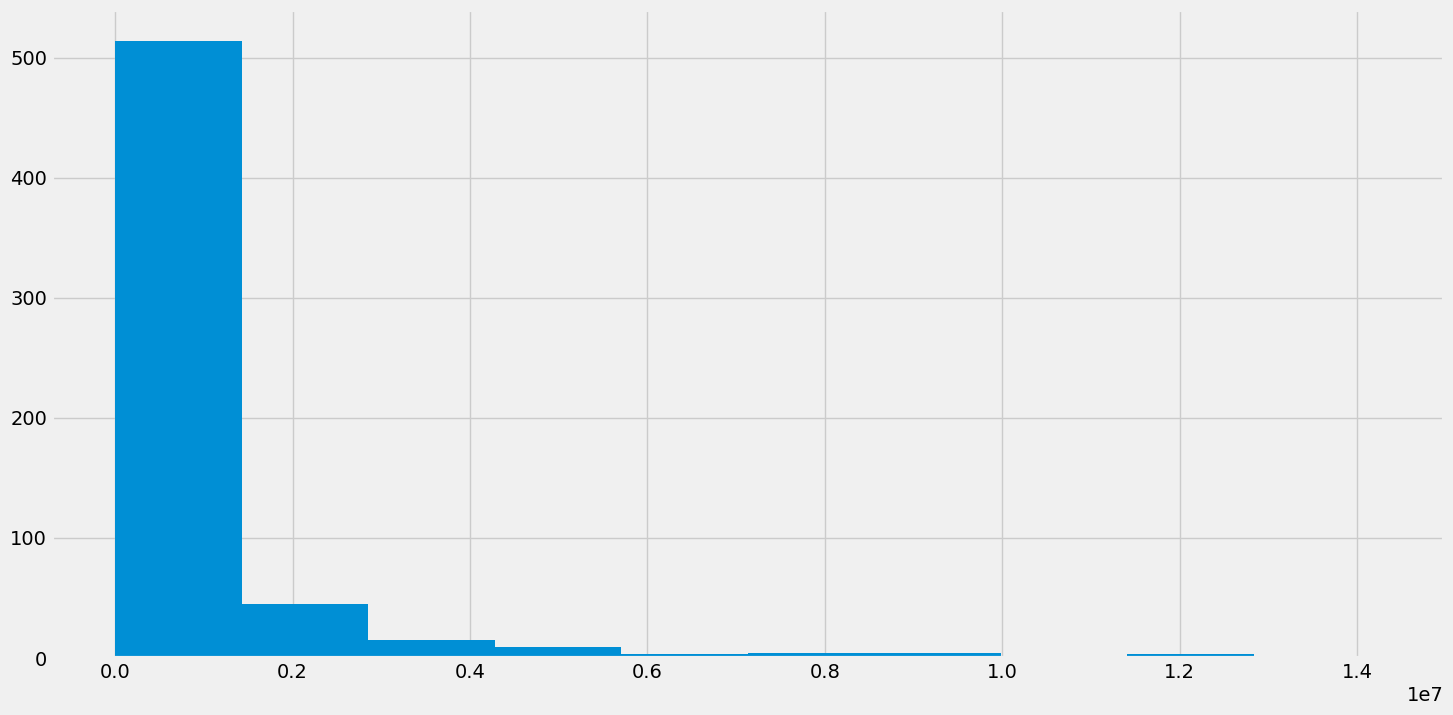

In [7]:
df[target_col].hist()

대부분 200만 언더. 멱함수 분포.

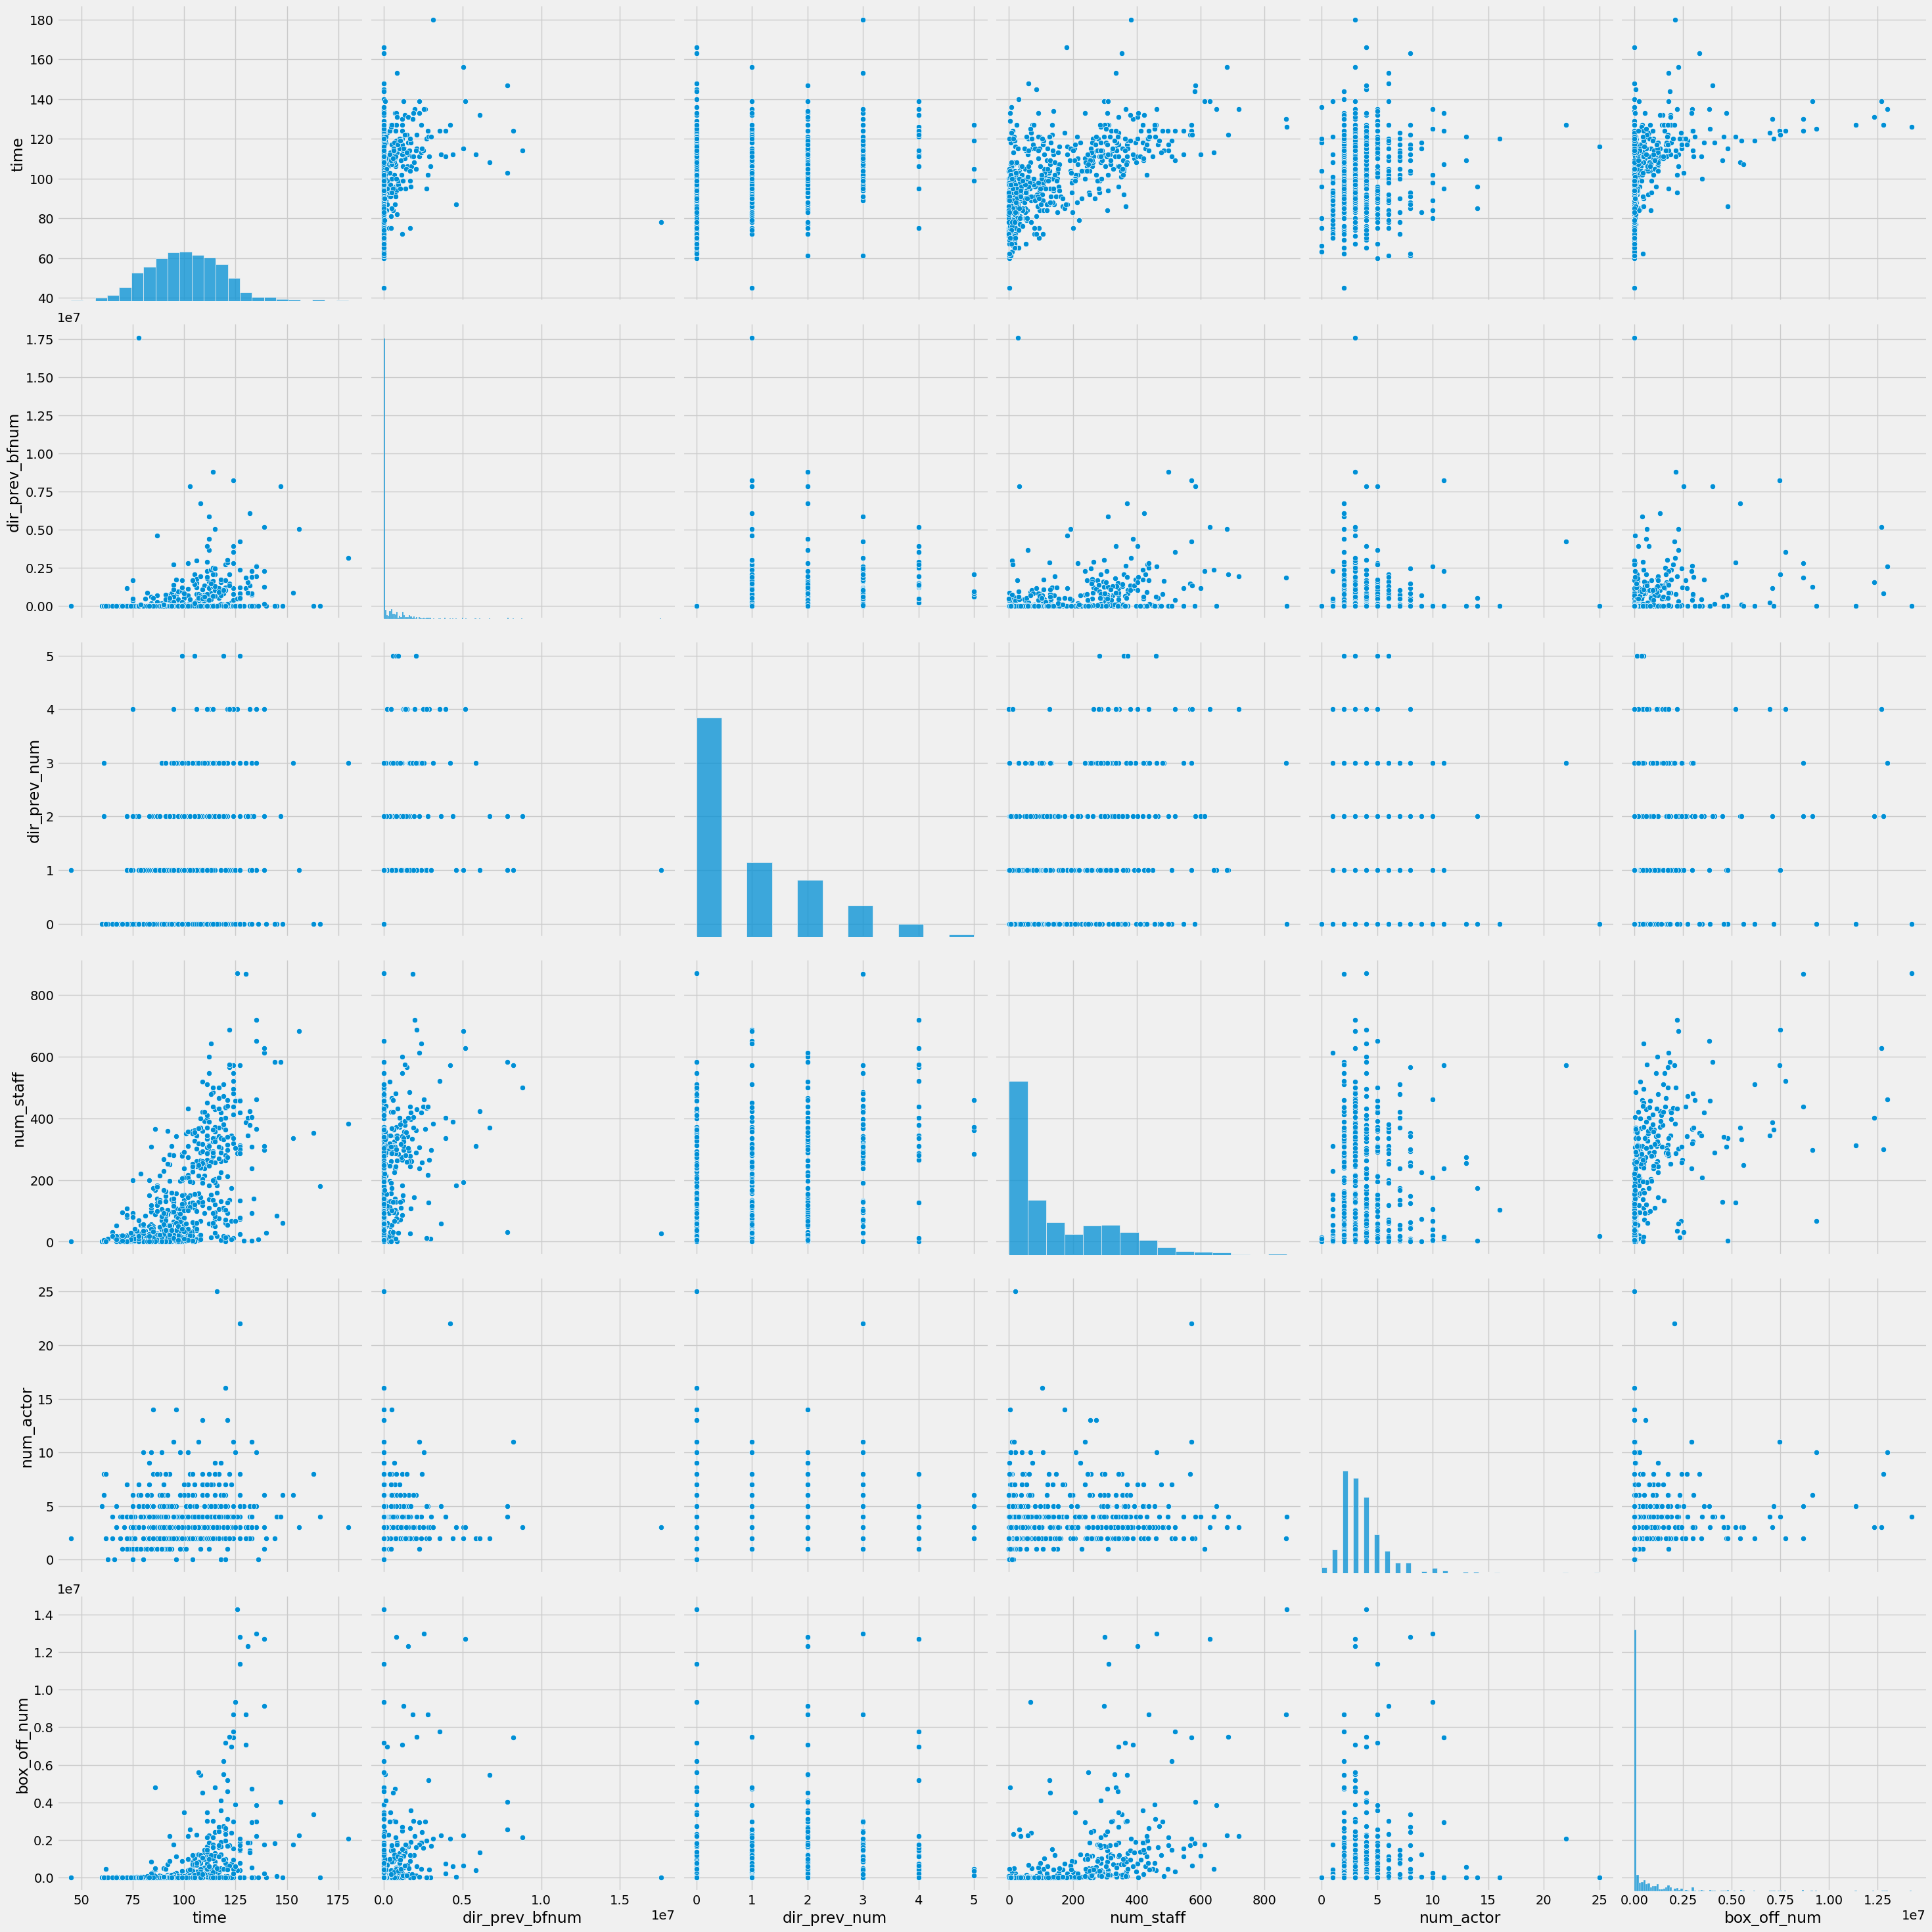

In [8]:
sns.pairplot(data=df, vars=num_cols + [target_col], size = 5)

time만이 정규분포에 가깝고, 나머지는 멱함수 power-law 함수에 가깝습니다

In [9]:
df[num_cols + [target_col]].corr().style.background_gradient()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
time,1.000000,0.266065,0.306727,0.623205,0.114153,0.441452
dir_prev_bfnum,0.266065,1.000000,0.396616,0.369657,0.042491,0.293791
dir_prev_num,0.306727,0.396616,1.000000,0.450706,0.014006,0.259674
num_staff,0.623205,0.369657,0.450706,1.000000,0.077871,0.544265
num_actor,0.114153,0.042491,0.014006,0.077871,1.000000,0.111179
box_off_num,0.441452,0.293791,0.259674,0.544265,0.111179,1.000000


## 선형회귀 모델 학습

### RMSE/RMLSE 손실함수 정의

In [10]:
rmse = lambda y, p: np.sqrt(mean_squared_error(y, p))
rmlse = lambda y, p: np.sqrt(mean_squared_error(np.log1p(y), np.log1p(p)))

변수 가공 없이 선형회귀 모델 학습

In [11]:
lr = LinearRegression()
lr.fit(df[num_cols], df[target_col])
df[pred_col] = lr.predict(df[num_cols])

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')


 RMSE:	  1500066.43


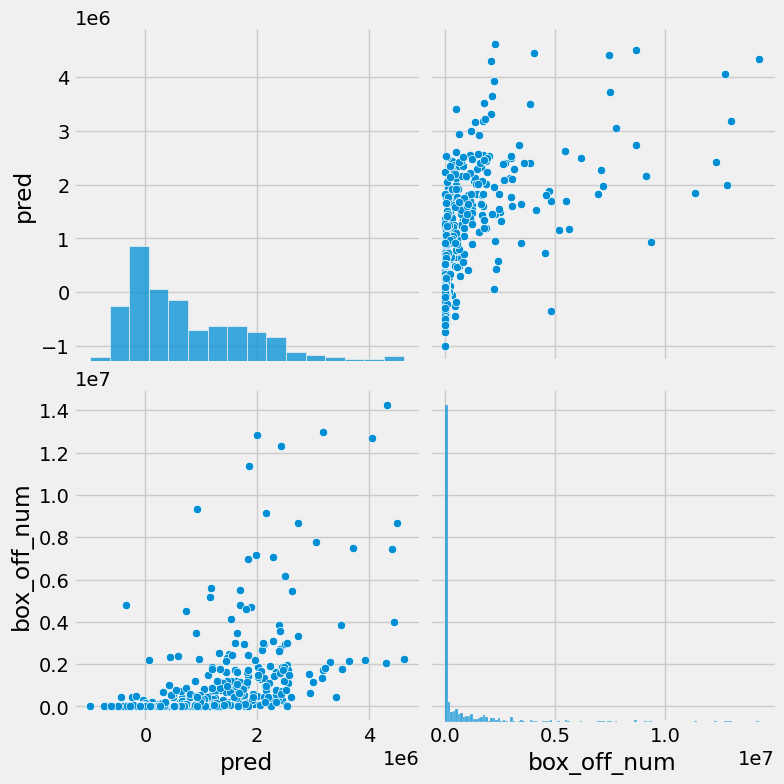

In [12]:
sns.pairplot(df, vars=[pred_col, target_col], size = 4)

멱함수의 경우, 작은 수들에 대해서 잘 예측하지 못합니다. 그래프를 보면 알 수 있는 것처럼, 실제로는 관객수가 0에 가깝지만, 예측값으로는 1백만, 2백만 3백만, 또는 심지어 음수로 예측한 경우도 있습니다.

## 멱함수 분포 변수 log1p 변환

이를 해결하기 위해, 종속변수 분포를 로그 변환합시다

<Axes: >

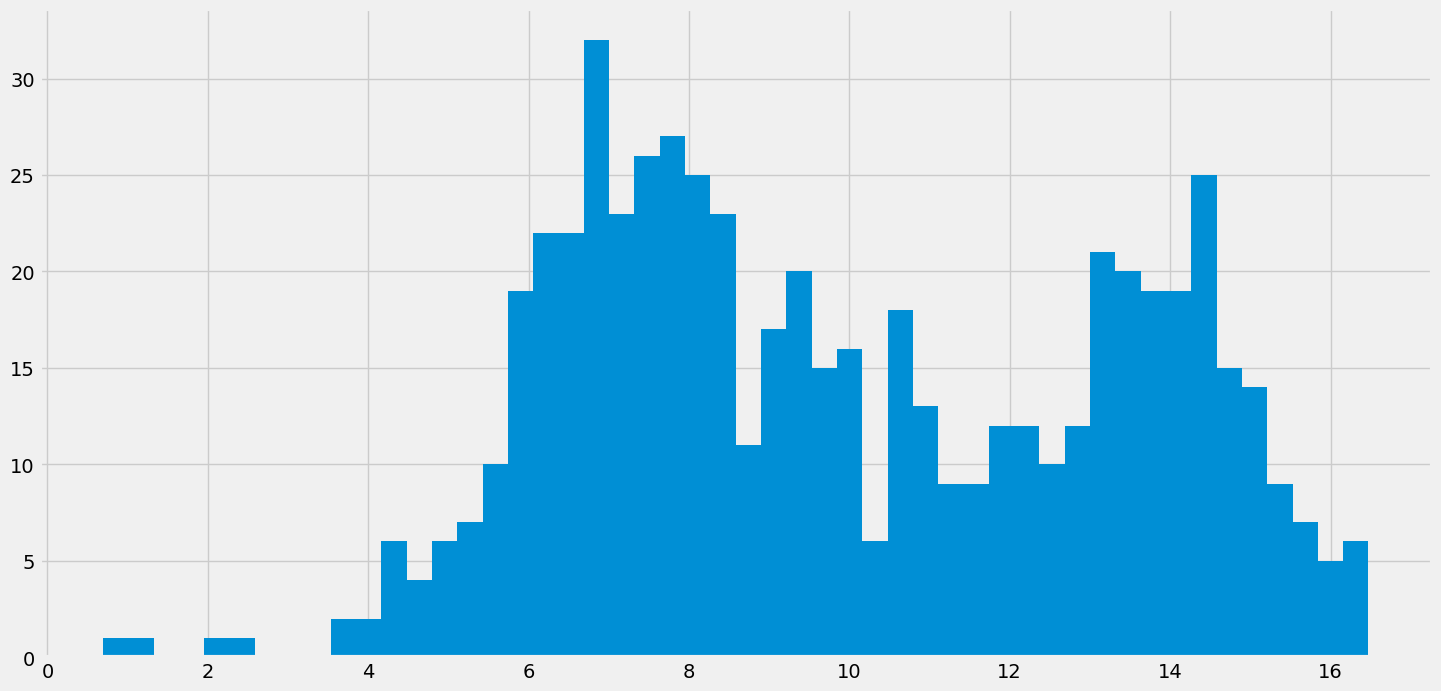

In [13]:
df.box_off_num.apply(np.log1p).hist(bins = 50)

정규분포에 더욱 가깝게 변했습니다.

현재, 종속분포를 로그화시켰기 때문에, 이 상태로 학습 후, 독립변수로 예측을 실행하면, 예측값이 로그화된 값 그대로 나옵니다. 때문에, 실제값으로 다시 역변환해줘야 합니다. np.expm1() 함수를 사용해서 역변환해줍니다.

In [14]:
lr = LinearRegression()
lr.fit(df[num_cols], np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(df[num_cols]))

print(f' RMSE : {rmse(df[target_col], df[pred_col]):12.2f}')
print(f' RMLSE : {rmlse(df[target_col], df[pred_col]):12.2f}')

 RMSE :  17129211.69
 RMLSE :         2.12


RMSE값이 매우 커진 것을 알 수가 있습니다. 그 이유는, 로그변환을 하게 되면 적은 숫자들에 대해서는 잘 예측하지만, 값이 큰 숫자에 대한 오차가 더 커져서 이러한 현상이 발생합니다.

5->10 , 3500 - > 4000. 전자의 경우를 더욱 에러가 크게 인지하여, 작은 수에 더욱 overfit하게 됨.

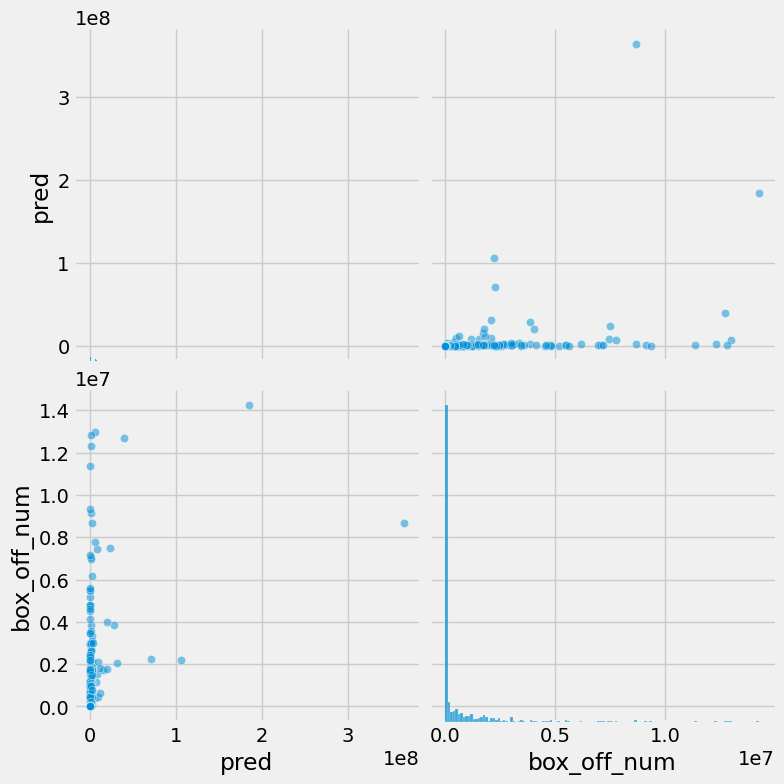

In [15]:
sns.pairplot(data=df, vars=[pred_col, target_col], size=4, plot_kws={'alpha': .5})


작은 수들에 대해 비교적 예측을 잘하는 것을 확인할 수가 있습니다.

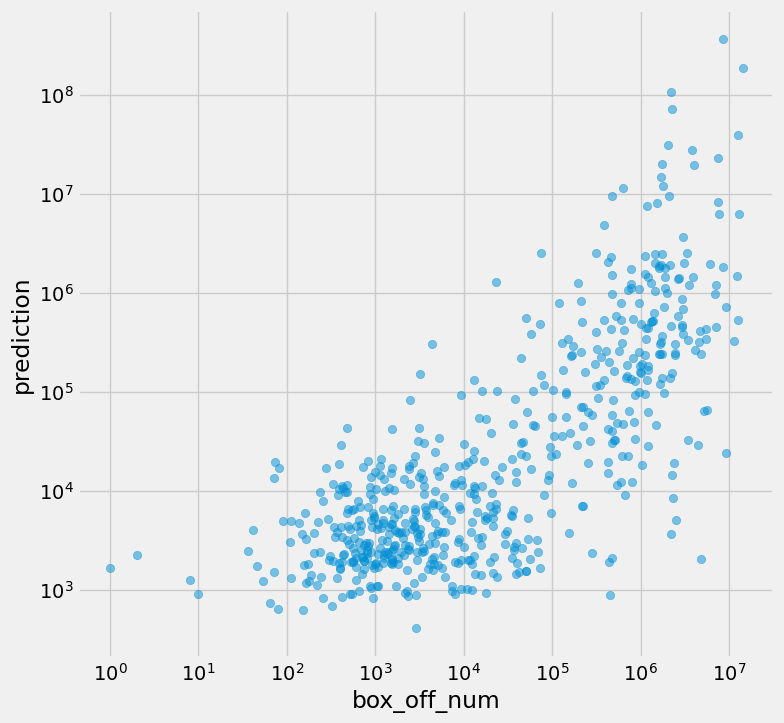

In [16]:
plt.figure(figsize=(8,8))
plt.scatter(df[target_col], df[pred_col], alpha=.5)
plt.xlabel('box_off_num')
plt.ylabel('prediction')
plt.yscale('log')
plt.xscale('log')

수치형 독립변수 중에도 멱변환 분포를 따르는 변수에도 로그화를 해줍시다

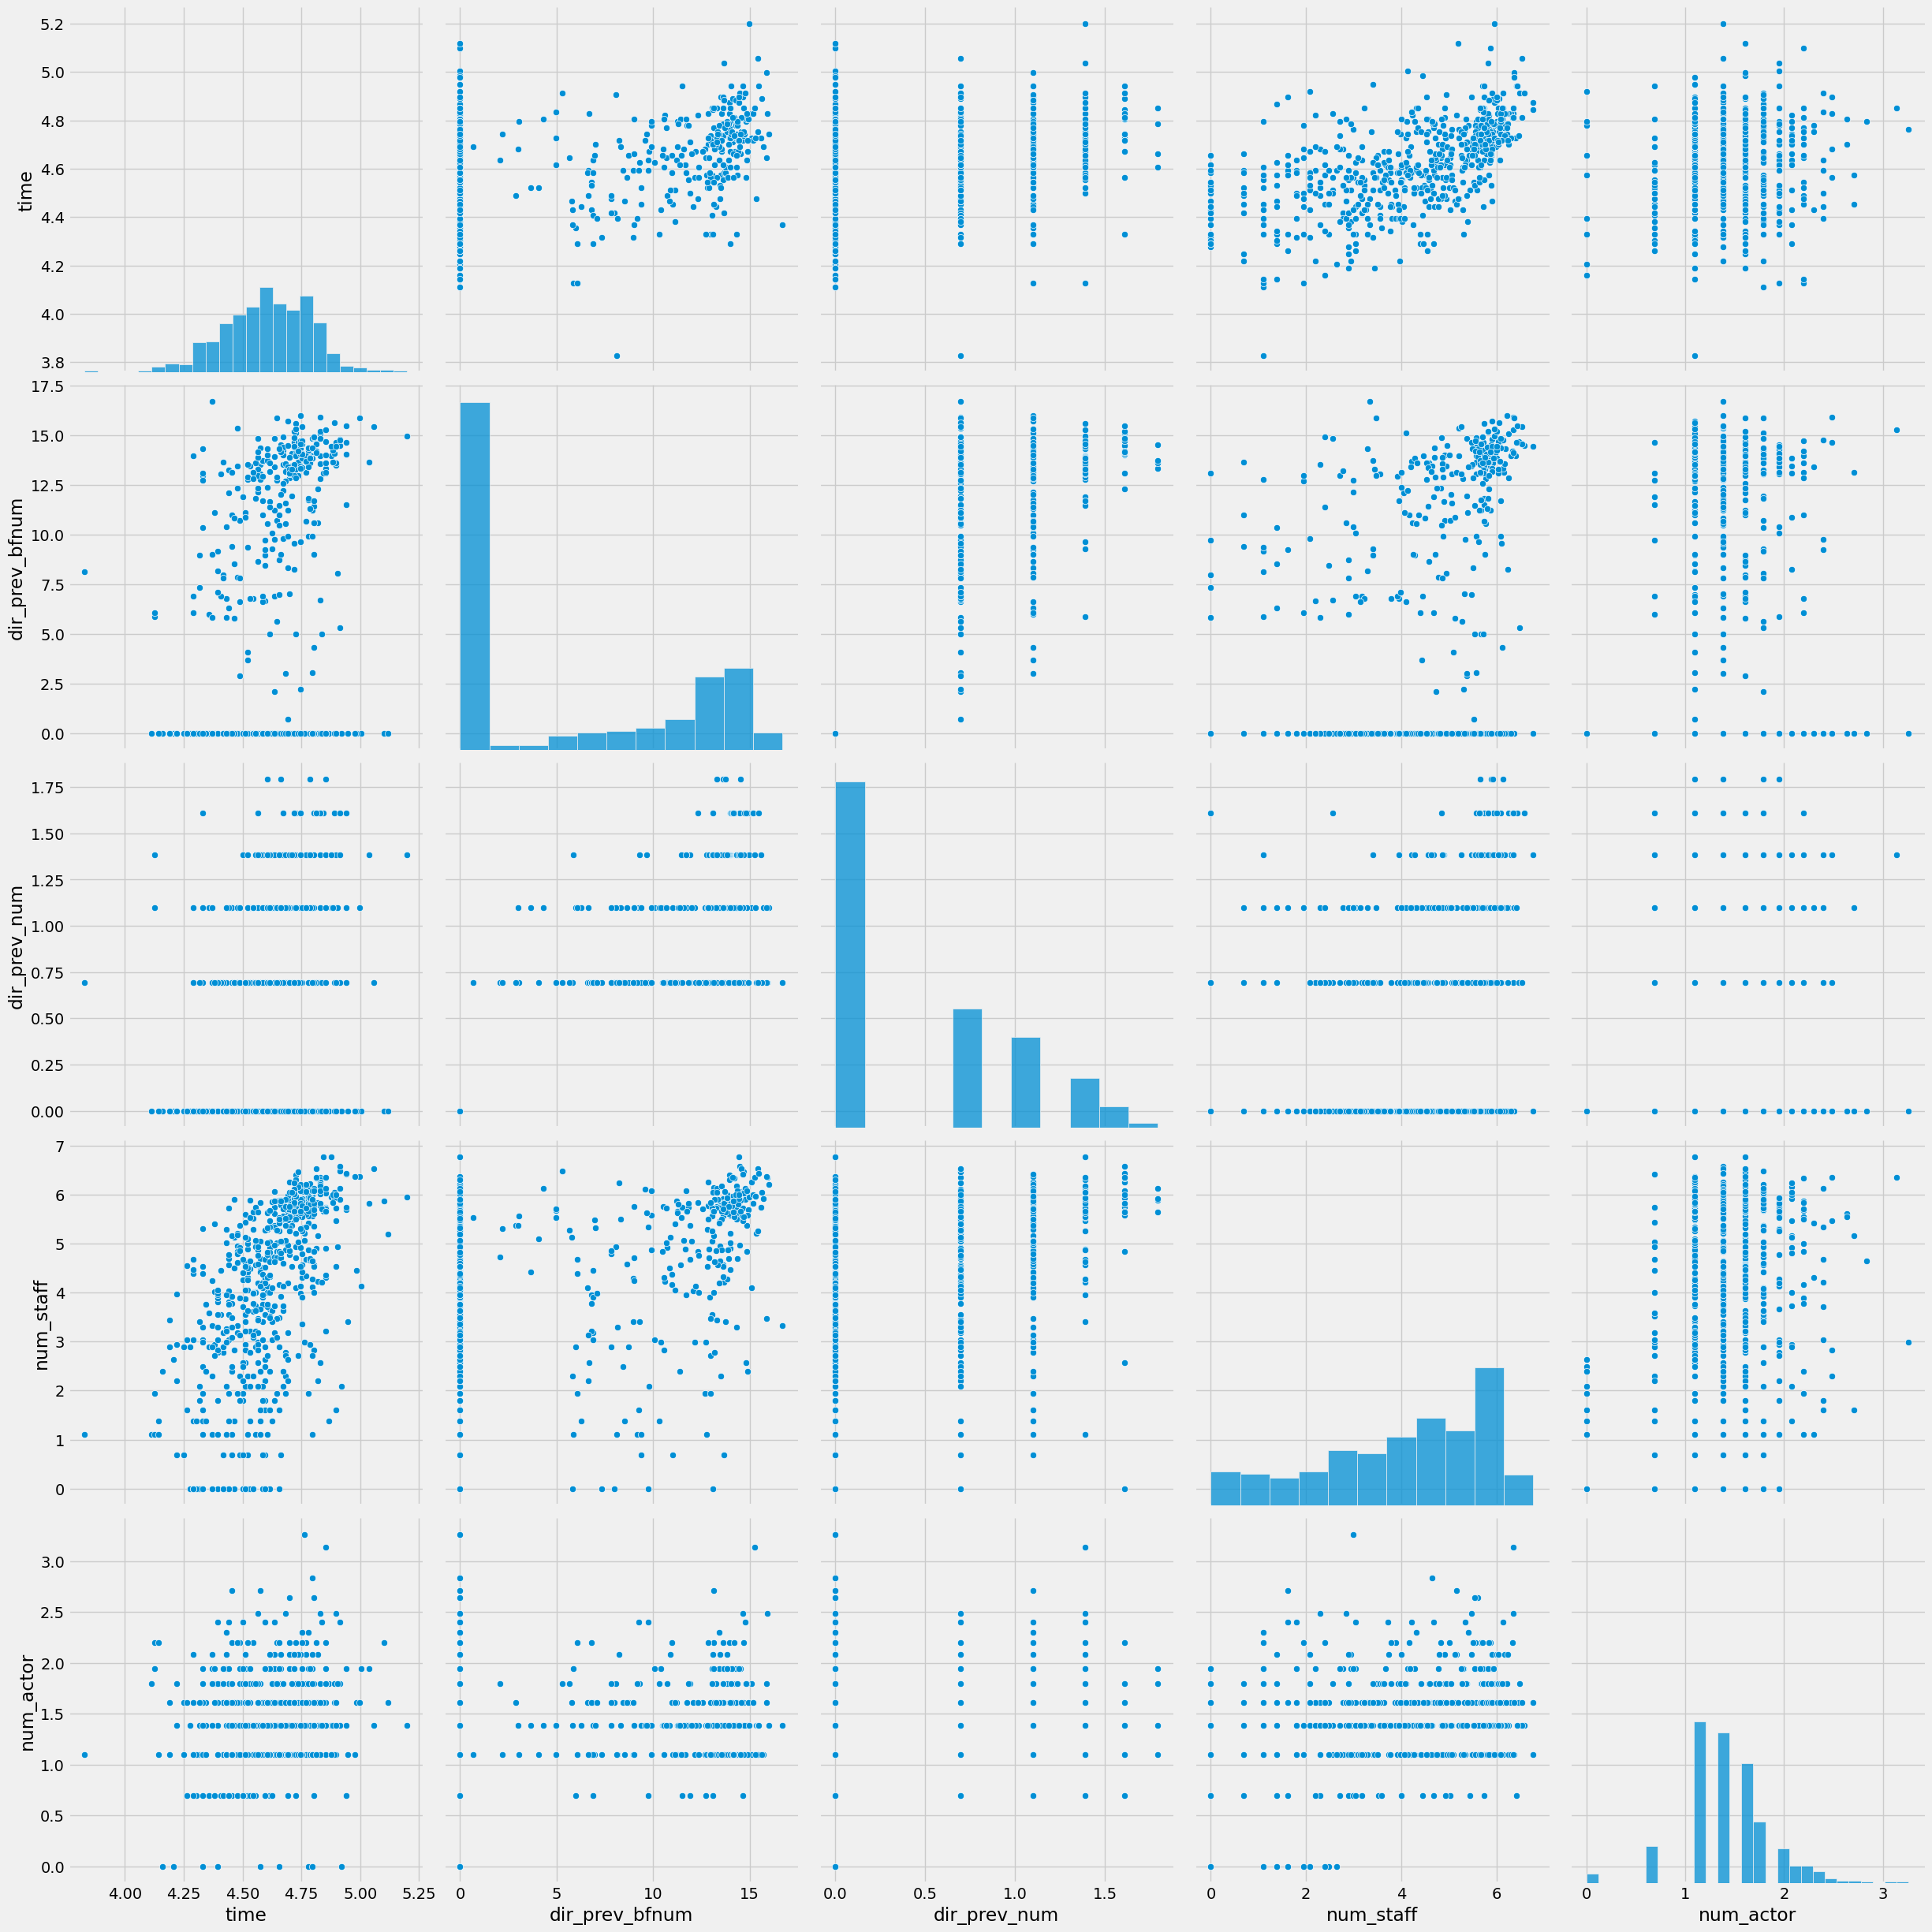

In [17]:
df[num_cols] = df[num_cols].apply(np.log1p)
sns.pairplot(df, vars=num_cols, size= 5)

독립변수를 로그화한 후, 학습시켜봅시다

In [18]:
lr = LinearRegression()
lr.fit(df[num_cols], np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(df[num_cols]))

print(f"RMSE {rmse(df[target_col], df[pred_col]):12.2f}")
print(f"RMLSE {rmlse(df[target_col], df[pred_col]):12.2f}")

RMSE   1771999.29
RMLSE         2.33


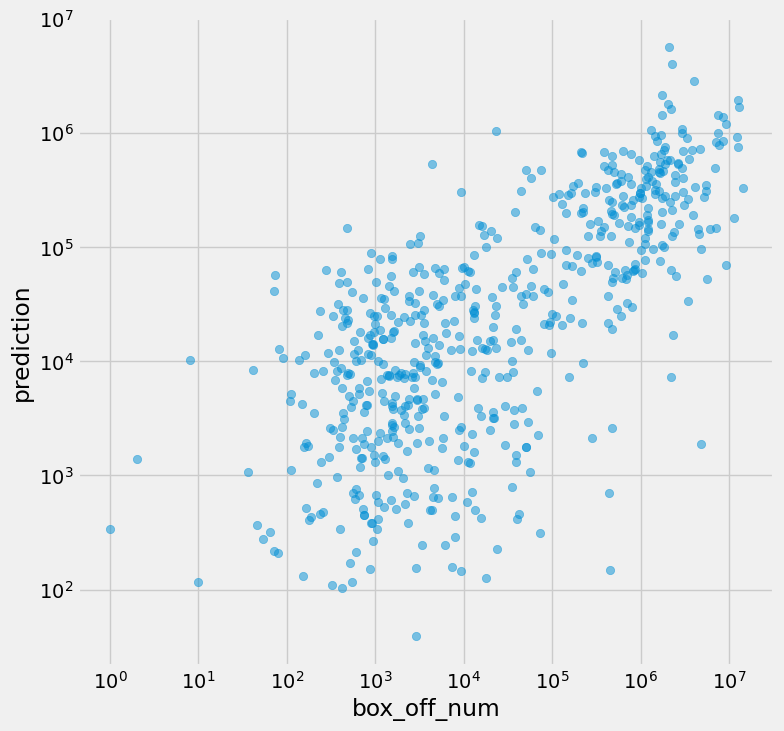

In [19]:
plt.figure(figsize=(8, 8))
plt.scatter(df[target_col], df[pred_col], alpha=.5)
plt.xlabel('box_off_num')
plt.ylabel('prediction')
plt.yscale('log')
plt.xscale('log')

# 날짜 / 시간 변수 처리.

날짜와 시간도 중요하게 사용될 수 있다.

날짜형 변수는 보통 처음에 문자열인데, 이거를 to_datetime() 함수로, datetime 데이터 타입으로 변환해주면, 일, 요일, 월, 년 등 시간 정보를 따로 추출할 수 있다.

In [20]:
df['release_time'] = pd.to_datetime(df['release_time'])
df['release_time'].describe()

count                    600
mean     2013-04-16 10:12:00
min      2010-01-02 00:00:00
25%      2011-10-11 06:00:00
50%      2013-07-17 12:00:00
75%      2014-10-16 00:00:00
max      2015-12-31 00:00:00
Name: release_time, dtype: object

In [21]:
df['year'] = df['release_time'].dt.year
df['month'] = df['release_time'].dt.month

In [22]:
num_cols += ['year', 'month']
print(num_cols)

['time', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor', 'year', 'month']


In [23]:
lr = LinearRegression()
lr.fit(df[num_cols], np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(df[num_cols]))

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')
print(f'RMLSE:\t{rmlse(df[target_col], df[pred_col]):12.2f}')

 RMSE:	  1777498.52
RMLSE:	        2.32


## 정규화 스케일링

- 알고리즘에 따라 수치형 변수 스케일링/정규분포화를 적용할 수 있습니다. 해당 방법은 선형회귀/결정트리류의 알고리즘에는 도움이 되지는 않습니다. 해당 알고리즘은 스케일이 무관하게 학습을 하지만, 신경망 네트워크 모델인 경우 스케일링이 중요하게 작용합니다. Exploded or Vanishing 방지용

In [24]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
X = scaler.fit_transform(df[num_cols])

lr = LinearRegression()
lr.fit(X, np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(X))

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')
print(f'RMLSE:\t{rmlse(df[target_col], df[pred_col]):12.2f}')

 RMSE:	  1777498.52
RMLSE:	        2.32


In [25]:
scaler = MinMaxScaler()
X = scaler.fit_transform(df[num_cols])

lr = LinearRegression()
lr.fit(X, np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(X))

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')
print(f'RMLSE:\t{rmlse(df[target_col], df[pred_col]):12.2f}')

 RMSE:	  1777498.52
RMLSE:	        2.32


## Binning

수치형 변수에는 binning을 적용할 수 있습니다. 수치형 변수를 각 계급별로 묶어서 하나의 카테고리로 표현할 수 있습니다.(수치형의 범주형 변수화). 또한, 이를 통해 hot encoding 기법을 통해, 피쳐 엔지니어링 또한 가능합니다.

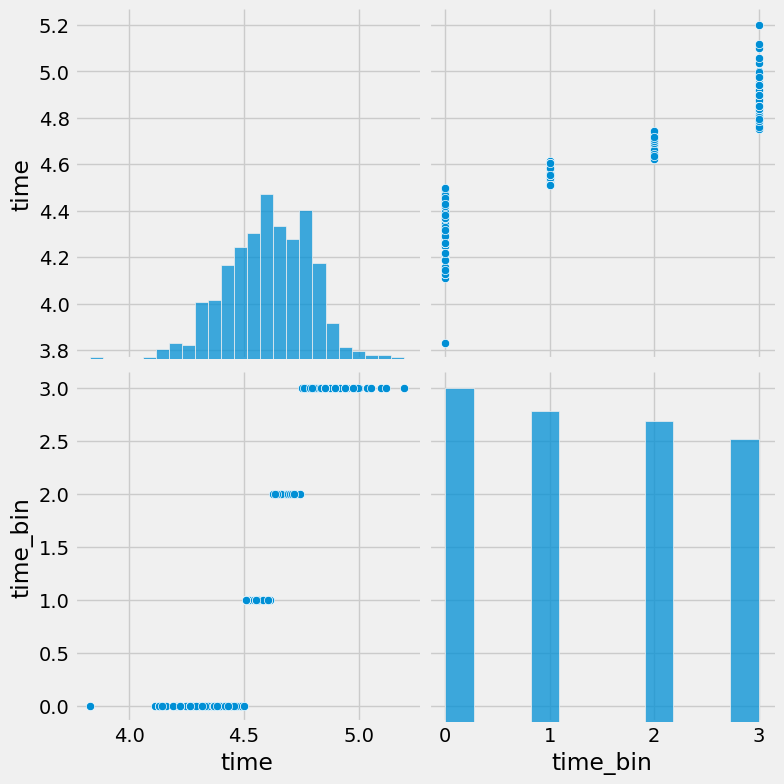

In [26]:
df['time_bin'] = pd.qcut(df['time'],4,labels=False)
sns.pairplot(data=df,vars=['time','time_bin'],size=4)

pd.qcut() 함수 -> 를 사용해 binning을 할 수 있습니다. 두 번째 파라미터에 4를 입력함으로써 총 4개의 bin으로 그룹을 짓게 됩니다. **qcut**. labels를 따로 지정해주지 않으면 0,1,2,3의 라벨을 부여합니다.

In [27]:
df[['time', 'time_bin']].head()

,time,time_bin
title,,
개들의 전쟁,4.574711,1
내부자들,4.875197,3
은밀하게 위대하게,4.820282,3
나는 공무원이다,4.624973,2
불량남녀,4.691348,2


In [29]:
X = pd.concat([df[num_cols], pd.get_dummies(df['time_bin'])], axis = 1)
X.shape

(600, 11)

In [36]:
X.head()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,year,month,0,1,2,3
title,,,,,,,,,,,
개들의 전쟁,4.574711,0.000000,0.000000,4.521789,1.098612,2012,11,False,True,False,False
내부자들,4.875197,13.965312,1.098612,5.961005,1.386294,2015,11,False,False,False,True
은밀하게 위대하게,4.820282,12.304905,1.609438,5.840642,1.609438,2013,6,False,False,False,True
나는 공무원이다,4.624973,10.081425,1.098612,3.044522,1.945910,2012,7,False,False,True,False
불량남녀,4.691348,0.693147,0.693147,5.529429,1.098612,2010,11,False,False,True,False


In [35]:
lr = LinearRegression()
X.columns = X.columns.astype(dtype='str')

lr.fit(X, np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(X))

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')
print(f'RMLSE:\t{rmlse(df[target_col], df[pred_col]):12.2f}')

 RMSE:	  1731196.42
RMLSE:	        2.25


month 컬럼 또한 1~12까지 해당하는 카테고리 변수니, 이 또한 더미함수로 핫코딩 해봅시다!

- 트리형에서는 인핫코딩이 유리 X. 오버피팅 가능성. But, 선형회귀나 신경망에서는 유용

In [38]:
X = pd.concat([df[[x for x in num_cols if x != 'month']],
               pd.get_dummies(pd.qcut(df['time'],4,labels=False)),
               pd.get_dummies(df['month'])], axis = 1)

X.shape

(600, 22)

In [40]:
lr = LinearRegression()
X.columns = X.columns.astype(dtype = 'str')
lr.fit(X, np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(X))

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')
print(f'RMLSE:\t{rmlse(df[target_col], df[pred_col]):12.2f}')

 RMSE:	  1695436.47
RMLSE:	        2.22


RMSE와 RMLSE가 둘 다 크게 감소한 것을 확인할 수 있습니다.

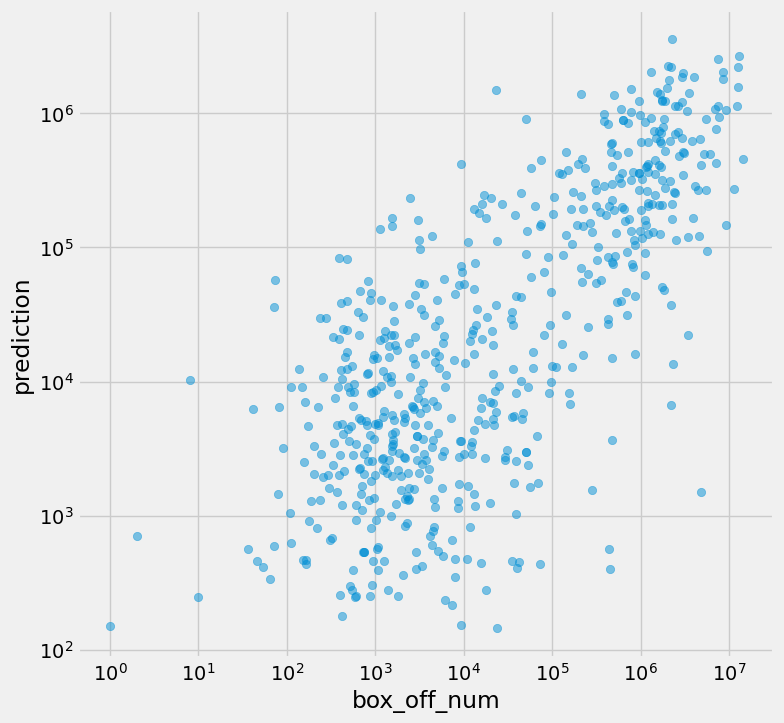

In [41]:
plt.figure(figsize=(8,8))
plt.scatter(df[target_col], df[pred_col], alpha = .5)
plt.xlabel('box_off_num')
plt.ylabel('prediction')
plt.yscale('log')
plt.xscale('log')

## 2차 다항회귀 Polynomial Regression

In [42]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)
X = poly.fit_transform(df[num_cols])
print(X.shape)

(600, 36)


In [43]:
lr = LinearRegression()
lr.fit(X, np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(X))

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')
print(f'RMLSE:\t{rmlse(df[target_col], df[pred_col]):12.2f}')

 RMSE:	  2728681.99
RMLSE:	        1.99


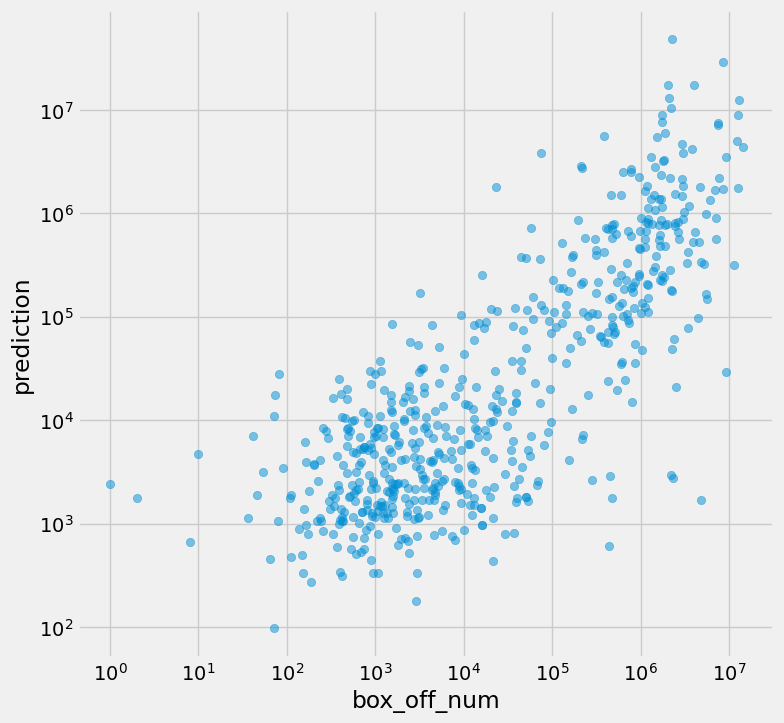

In [44]:
plt.figure(figsize=(8, 8))
plt.scatter(df[target_col], df[pred_col], alpha=.5)
plt.xlabel('box_off_num')
plt.ylabel('prediction')
plt.yscale('log')
plt.xscale('log')